# Bone X-Ray abnormality detection - Body Part Classification

**Problem**

Given a study containing X-Ray images build a deep learning model that decides if the study is normal or abnormal. We use at least two different architectures, one using a CNN we have created from scratch and one using a pre-trained popular CNN (e.g., ResNet).
We use the MURA dataset to train and evaluate your models. More information about the task 
and the dataset can be found at https://stanfordmlgroup.github.io/competitions/mura/

# Libraries

In [1]:
!nvidia-smi

Sat Mar 30 17:31:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install keras-adabound

  Preparing metadata (setup.py) ... done
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6609 sha256=b1d5e9f1fe7ab2ad5f75e8ba8ba4de6a8cd95c3d4f028a541feab376fec22153
  Stored in directory: /root/.cache/pip/wheels/3e/bf/39/3d95847ef12aa58c15a6cc7a20f4f21ea39fcd52793e1beea0
Successfully built keras-adabound


In [3]:
!pip install tensorflow_addons

In [4]:
import os
import random

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from enum import Enum

import cv2

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc

from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#optimizers
from tensorflow.keras.optimizers import SGD, Adam
from keras_adabound import AdaBound

from tensorflow.keras.losses import BinaryCrossentropy

# Layers to be used for building our model
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential

from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score

#Pretrained models
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201

#For Ensemblers
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier

In [5]:
# define seed number to have reproducible experiments.
seed = 3352024

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data

This data comes as split dataset (training & validation in separate directories). Each data categories such as training & validation has sub-directories (pls see below).


```

└─train {data category}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data category}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
                        └───...
```

## Download dataset

In [6]:
#!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

In [7]:
#!unzip MURA-v1.1.zip

## First way to load dataset

**Load dataset**

In [8]:
def load_path(path):
    
    '''
    load MURA dataset
    '''
    
    dataset = [] 

    for body in os.listdir(path):
        body_part = body

    #     print(os.listdir(path_p))
        path_p = path+'/'+str(body)

        for id_p in os.listdir(path_p):

            patient_id = id_p

            path_id = path_p+'/'+str(id_p)
    #         print(os.listdir(path_id))

            for lab in os.listdir(path_id):

                #positive Label is 1, otherwise 0
                #directory file patient11880\\study1_negative\\image3.png
                if lab.split('_')[-1]=='positive': 
                    label = 1 
                elif lab.split('_')[-1]=='negative':
                    label= 0

                path_l = path_id+'/'+str(lab)
    #             print(os.listdir(path_l))   
    #             print('----')

                for img in os.listdir(path_l):
    #                   print(img)
                    img_path = path_l + '/' + str(img)

                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

In [9]:
path = '../input/mura-v11/MURA-v1.1/train'
os.listdir(path)

['XR_WRIST',
 'XR_FINGER',
 'XR_SHOULDER',
 'XR_HAND',
 'XR_FOREARM',
 'XR_HUMERUS',
 'XR_ELBOW']

**Train set**

In [10]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train 

,body_part,patient_id,label,img_path
0,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
1,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
2,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
3,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
4,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
...,...,...,...,...
36807,XR_ELBOW,patient05086,1,../input/mura-v11/MURA-v1.1/train/XR_ELBOW/pat...
36808,XR_ELBOW,patient05086,1,../input/mura-v11/MURA-v1.1/train/XR_ELBOW/pat...
36809,XR_ELBOW,patient05950,0,../input/mura-v11/MURA-v1.1/train/XR_ELBOW/pat...
36810,XR_ELBOW,patient05950,0,../input/mura-v11/MURA-v1.1/train/XR_ELBOW/pat...


In [11]:
df_train.img_path[3]

'../input/mura-v11/MURA-v1.1/train/XR_WRIST/patient07547/study2_negative/image1.png'

In [12]:
df_train.img_path[4]

'../input/mura-v11/MURA-v1.1/train/XR_WRIST/patient07547/study2_negative/image3.png'

**Test set**

In [13]:
dataset_test = load_path(path = '../input/mura-v11/MURA-v1.1/valid')
df_test = pd.DataFrame(dataset_test)
df_test

,body_part,patient_id,label,img_path
0,XR_WRIST,patient11268,1,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
1,XR_WRIST,patient11268,1,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
2,XR_WRIST,patient11268,1,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
3,XR_WRIST,patient11302,0,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
4,XR_WRIST,patient11380,0,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
...,...,...,...,...
3192,XR_ELBOW,patient11866,0,../input/mura-v11/MURA-v1.1/valid/XR_ELBOW/pat...
3193,XR_ELBOW,patient11414,1,../input/mura-v11/MURA-v1.1/valid/XR_ELBOW/pat...
3194,XR_ELBOW,patient11414,1,../input/mura-v11/MURA-v1.1/valid/XR_ELBOW/pat...
3195,XR_ELBOW,patient11869,0,../input/mura-v11/MURA-v1.1/valid/XR_ELBOW/pat...


In [14]:
df_train.to_csv("/kaggle/working/mura_train.csv")

In [15]:
df_test.to_csv("/kaggle/working/mura_test.csv")

## Alternative way to load dataset

inspired from https://www.kaggle.com/hasnaatawfik/mura-classification?fbclid=IwAR0uW8oNPMdcBMUe6keuRUmCNPp57rOCbH6Cg8gMB6lqNpwW2bW36XjMRxw

- image_path : the absolute path to image
- label : positive/negative the case classification
- category : the part of body in the image (XR_WRIST,XR_SHOULDER,XR_HAND,XR_FINGER,XR_ELBOW,XR_FOREARM,XR_HUMERUS)
- patientId :the study subfolder name withch refer to specific patient

We explore in paragraph "Explore alternative way", why we use two ways for load dataset

**Training set**

In [16]:
#csv files path
path = '../input/mura-v11/MURA-v1.1'
#csv files names
train_image_paths_csv = "train_image_paths.csv"

In [17]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

In [18]:
train_images_paths['label'] = train_images_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')

train_images_paths['category']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[2])  
train_images_paths['patientId']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train_images_paths.head()

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002


In [19]:
total_number_of_training_images = np.shape(train_images_paths)[0]
print("total number of images:",total_number_of_training_images )

total number of images: 36808


**Test set**

In [20]:
#csv files path
path = '../input/mura-v11/MURA-v1.1'
#csv files names
valid_image_paths_csv = "valid_image_paths.csv"
valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_data_paths.columns = ['image_path']

In [21]:
valid_data_paths['label'] = valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_data_paths['category']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])  
valid_data_paths['dir'] =  valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
valid_data_paths['patientId']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid_data_paths.head()

,image_path,label,category,dir,patientId
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186


In [22]:
total_number_of_valid_images = np.shape(valid_data_paths)[0]
print("total number of images:",total_number_of_valid_images )

total number of images: 3197


## Preprocessing

Like a One hot encode

In [23]:
train_images_paths

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
...,...,...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,negative,XR_HAND,11183
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,negative,XR_HAND,11183
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184


In [24]:
train_images_paths['label_index']= train_images_paths.category

In [25]:
train_images_paths.category.unique()

array(['XR_SHOULDER', 'XR_HUMERUS', 'XR_FINGER', 'XR_ELBOW', 'XR_WRIST',
       'XR_FOREARM', 'XR_HAND'], dtype=object)

In [26]:
train_images_paths.label_index.replace('XR_SHOULDER', 6, inplace=True)
train_images_paths.label_index.replace('XR_HUMERUS', 5, inplace=True)
train_images_paths.label_index.replace('XR_FINGER', 4, inplace=True)
train_images_paths.label_index.replace('XR_ELBOW', 3, inplace=True)
train_images_paths.label_index.replace('XR_WRIST', 2, inplace=True)
train_images_paths.label_index.replace('XR_FOREARM', 1, inplace=True)
train_images_paths.label_index.replace('XR_HAND', 0, inplace=True)

In [27]:
train_images_paths.head(3)

,image_path,label,category,patientId,label_index
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,6
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,6
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,6


In [28]:
train_images_paths.tail(3)

,image_path,label,category,patientId,label_index
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184,0
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184,0
36807,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184,0


In [29]:
valid_data_paths['label_index']= valid_data_paths.category
valid_data_paths.label_index.replace('XR_SHOULDER', 6, inplace=True)
valid_data_paths.label_index.replace('XR_HUMERUS', 5, inplace=True)
valid_data_paths.label_index.replace('XR_FINGER', 4, inplace=True)
valid_data_paths.label_index.replace('XR_ELBOW', 3, inplace=True)
valid_data_paths.label_index.replace('XR_WRIST', 2, inplace=True)
valid_data_paths.label_index.replace('XR_FOREARM', 1, inplace=True)
valid_data_paths.label_index.replace('XR_HAND', 0, inplace=True)
valid_data_paths.head(3)

,image_path,label,category,dir,patientId,label_index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,2
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,2
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,2


# Data Exploratory Analysis

## Explore dataset

In [30]:
print('We have '+str(len(df_train))+' train images from all body parts')

We have 36812 train images from all body parts


In [31]:
print('We have Bone X-Ray from: ')
path = '../input/mura-v11/MURA-v1.1/train'
print(*os.listdir(path), sep = "\n")

We have Bone X-Ray from: 
XR_WRIST
XR_FINGER
XR_SHOULDER
XR_HAND
XR_FOREARM
XR_HUMERUS
XR_ELBOW


## Explore body parts of dataset

In [32]:
grouped = df_train.groupby(df_train.body_part)
df_XR_ELBOW = grouped.get_group("XR_ELBOW")
df_XR_ELBOW.head(4)

,body_part,patient_id,label,img_path
31881,XR_ELBOW,patient05626,0,../input/mura-v11/MURA-v1.1/train/XR_ELBOW/pat...
31882,XR_ELBOW,patient05626,0,../input/mura-v11/MURA-v1.1/train/XR_ELBOW/pat...
31883,XR_ELBOW,patient06133,0,../input/mura-v11/MURA-v1.1/train/XR_ELBOW/pat...
31884,XR_ELBOW,patient06133,0,../input/mura-v11/MURA-v1.1/train/XR_ELBOW/pat...


In [33]:
print("Number of training XR_ELBOW: ",len(df_XR_ELBOW))

Number of training XR_ELBOW:  4931


In [34]:
training_data_distr = []

In [35]:
def count_distrib(df_body, body_name):
    '''
    count and print the number of positive,negative and total X-Ray for a part of body
    
    df_body : the dataframe of the part of the body that we will calculate
    body_name: a string name of the part of body that we focus on it
    
    '''
    grouped = df_body.groupby(df_body.label)
    
    pos = len(grouped.get_group(1))
    
    print('We have ' +str(pos)+ ' positive '+ body_name)
    
    print('vs')
    
    neg = len(grouped.get_group(0))
    print( 'We have ' +str(neg)+ ' negative '+ body_name)
    
    total = len(df_body)
    
    return body_name, pos, neg, total

In [36]:
body_name, pos, neg, total = count_distrib(df_XR_ELBOW, 'XR_ELBOW')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 2006 positive XR_ELBOW
vs
We have 2925 negative XR_ELBOW


In [37]:
df_XR_FINGER = grouped.get_group("XR_FINGER")
df_XR_FINGER.head(4)

,body_part,patient_id,label,img_path
9756,XR_FINGER,patient04480,0,../input/mura-v11/MURA-v1.1/train/XR_FINGER/pa...
9757,XR_FINGER,patient04480,0,../input/mura-v11/MURA-v1.1/train/XR_FINGER/pa...
9758,XR_FINGER,patient04480,0,../input/mura-v11/MURA-v1.1/train/XR_FINGER/pa...
9759,XR_FINGER,patient04453,0,../input/mura-v11/MURA-v1.1/train/XR_FINGER/pa...


In [38]:
print("Number of training XR_FINGER: ",len(df_XR_FINGER))

Number of training XR_FINGER:  5106


In [39]:
body_name, pos, neg, total = count_distrib(df_XR_FINGER, 'XR_FINGER')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 1968 positive XR_FINGER
vs
We have 3138 negative XR_FINGER


In [40]:
df_XR_FOREARM = grouped.get_group("XR_FOREARM")
df_XR_FOREARM.head(4)

,body_part,patient_id,label,img_path
28784,XR_FOREARM,patient05601,1,../input/mura-v11/MURA-v1.1/train/XR_FOREARM/p...
28785,XR_FOREARM,patient05601,1,../input/mura-v11/MURA-v1.1/train/XR_FOREARM/p...
28786,XR_FOREARM,patient05601,1,../input/mura-v11/MURA-v1.1/train/XR_FOREARM/p...
28787,XR_FOREARM,patient06858,0,../input/mura-v11/MURA-v1.1/train/XR_FOREARM/p...


In [41]:
print("Number of training XR_FOREARM: ",len(df_XR_FOREARM))

Number of training XR_FOREARM:  1825


In [42]:
body_name, pos, neg, total = count_distrib(df_XR_FOREARM, 'XR_FOREARM')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 661 positive XR_FOREARM
vs
We have 1164 negative XR_FOREARM


In [43]:
df_XR_HAND = grouped.get_group("XR_HAND")
df_XR_HAND.head(4)

,body_part,patient_id,label,img_path
23241,XR_HAND,patient09779,1,../input/mura-v11/MURA-v1.1/train/XR_HAND/pati...
23242,XR_HAND,patient09779,1,../input/mura-v11/MURA-v1.1/train/XR_HAND/pati...
23243,XR_HAND,patient10150,0,../input/mura-v11/MURA-v1.1/train/XR_HAND/pati...
23244,XR_HAND,patient10150,0,../input/mura-v11/MURA-v1.1/train/XR_HAND/pati...


In [44]:
print("Number of training XR_HAND: ",len(df_XR_HAND))

Number of training XR_HAND:  5543


In [45]:
body_name, pos, neg, total = count_distrib(df_XR_HAND, 'XR_HAND')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 1484 positive XR_HAND
vs
We have 4059 negative XR_HAND


In [46]:
df_XR_HUMERUS = grouped.get_group("XR_HUMERUS")
df_XR_HUMERUS.head(4)

,body_part,patient_id,label,img_path
30609,XR_HUMERUS,patient03016,0,../input/mura-v11/MURA-v1.1/train/XR_HUMERUS/p...
30610,XR_HUMERUS,patient03016,0,../input/mura-v11/MURA-v1.1/train/XR_HUMERUS/p...
30611,XR_HUMERUS,patient03016,0,../input/mura-v11/MURA-v1.1/train/XR_HUMERUS/p...
30612,XR_HUMERUS,patient02935,1,../input/mura-v11/MURA-v1.1/train/XR_HUMERUS/p...


In [47]:
print("Number of training XR_HUMERUS: ",len(df_XR_HUMERUS))

Number of training XR_HUMERUS:  1272


In [48]:
body_name, pos, neg, total = count_distrib(df_XR_HUMERUS, 'XR_HUMERUS')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 599 positive XR_HUMERUS
vs
We have 673 negative XR_HUMERUS


In [49]:
df_XR_SHOULDER = grouped.get_group("XR_SHOULDER")
df_XR_SHOULDER.head(4)

,body_part,patient_id,label,img_path
14862,XR_SHOULDER,patient00734,1,../input/mura-v11/MURA-v1.1/train/XR_SHOULDER/...
14863,XR_SHOULDER,patient00746,1,../input/mura-v11/MURA-v1.1/train/XR_SHOULDER/...
14864,XR_SHOULDER,patient00746,1,../input/mura-v11/MURA-v1.1/train/XR_SHOULDER/...
14865,XR_SHOULDER,patient00746,1,../input/mura-v11/MURA-v1.1/train/XR_SHOULDER/...


In [50]:
print("Number of training XR_SHOULDER: ",len(df_XR_SHOULDER))

Number of training XR_SHOULDER:  8379


In [51]:
body_name, pos, neg, total = count_distrib(df_XR_SHOULDER, 'XR_SHOULDER')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 4168 positive XR_SHOULDER
vs
We have 4211 negative XR_SHOULDER


In [52]:
df_XR_WRIST = grouped.get_group("XR_WRIST")
df_XR_WRIST.head(4)

,body_part,patient_id,label,img_path
0,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
1,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
2,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
3,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...


In [53]:
print("Number of training XR_WRIST: ",len(df_XR_WRIST))

Number of training XR_WRIST:  9756


In [54]:
body_name, pos, neg, total = count_distrib(df_XR_WRIST, 'XR_WRIST')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 3987 positive XR_WRIST
vs
We have 5769 negative XR_WRIST


## Explore with plots

In [55]:
training_data_distr = pd.DataFrame(training_data_distr)

In [56]:
training_data_distr['percentage'] = round(100 * training_data_distr['total'] / len(df_train.body_part), 2)

In [57]:
print('Training Data Distribution')
training_data_distr

Training Data Distribution


,body_part,positive,negative,total,percentage
0,XR_ELBOW,2006,2925,4931,13.40
1,XR_FINGER,1968,3138,5106,13.87
2,XR_FOREARM,661,1164,1825,4.96
3,XR_HAND,1484,4059,5543,15.06
4,XR_HUMERUS,599,673,1272,3.46
5,XR_SHOULDER,4168,4211,8379,22.76
6,XR_WRIST,3987,5769,9756,26.50


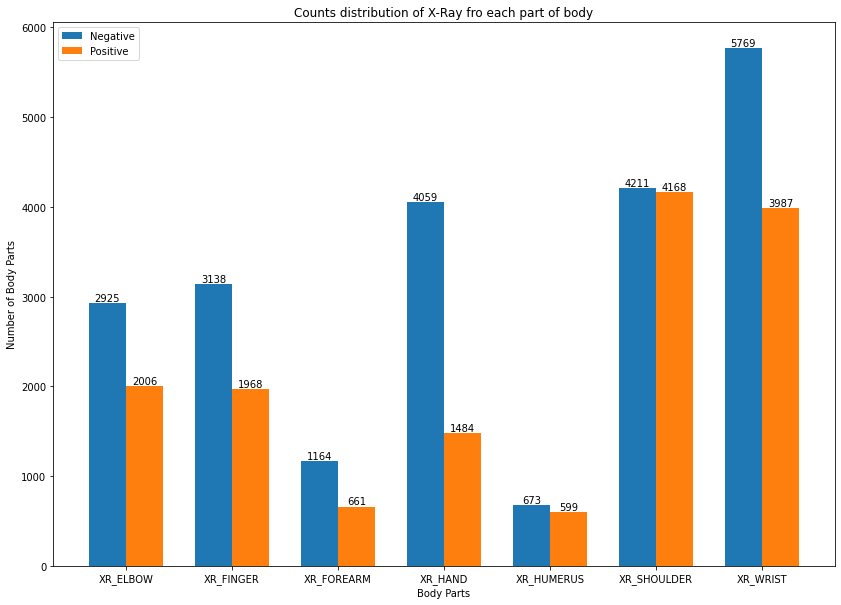

In [58]:
labels = training_data_distr['body_part']
negative = training_data_distr['negative']
positive = training_data_distr['positive']

x = np.arange(len(labels))
width = 0.35

fig = plt.figure(figsize=(14, 10))

ax = fig.subplots()
rects1 = ax.bar(x - width/2, negative, width, label='Negative')
rects2 = ax.bar(x + width/2, positive, width, label='Positive')
ax.set_ylabel('Number of Body Parts')
ax.set_xlabel('Body Parts')
ax.set_title('Counts distribution of X-Ray fro each part of body')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.00*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [59]:
grouped = df_train.groupby(df_train.label)
    
pos = len(grouped.get_group(1))
neg = len(grouped.get_group(0))

In [60]:
print("Number of positives:",pos)
print("Number of negatives:",neg)

Number of positives: 14873
Number of negatives: 21939


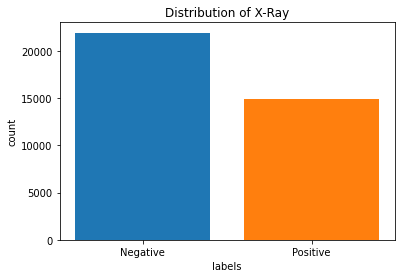

In [61]:
# the data you want to plot
categories = ["Negative"]
values     = [ neg]

categories2 = ["Positive"]
values2     = [  pos]

plt.bar(categories, values)
plt.bar(categories2, values2)

# Add title and axis names
plt.title('Distribution of X-Ray')
plt.xlabel('labels')
plt.ylabel('count')


plt.show()

**Test set**

In [62]:
grouped = valid_data_paths.groupby(valid_data_paths.label)
    
pos = len(grouped.get_group('positive'))
neg = len(grouped.get_group('negative'))

In [63]:
print("Number of positives:",pos)
print("Number of negatives:",neg)

Number of positives: 1530
Number of negatives: 1667


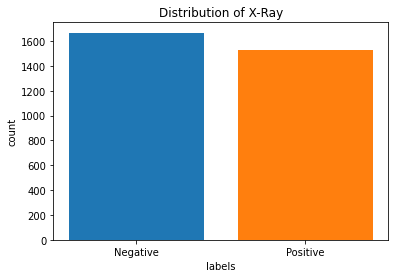

In [64]:
# the data you want to plot
categories = ["Negative"]
values     = [ neg]

categories2 = ["Positive"]
values2     = [  pos]

plt.bar(categories, values)
plt.bar(categories2, values2)

# Add title and axis names
plt.title('Distribution of X-Ray')
plt.xlabel('labels')
plt.ylabel('count')


plt.show()

The dataset of test data is far more balance than train data.


## Explore alternative way

**Summary of alternative way**

In [65]:
#https://www.kaggle.com/hasnaatawfik/mura-classification?fbclid=IwAR0uW8oNPMdcBMUe6keuRUmCNPp57rOCbH6Cg8gMB6lqNpwW2bW36XjMRxw
total_number_of_training_images = np.shape(train_images_paths)[0]
print ("\n\nnumber of null values in:\n", train_images_paths.isnull().sum())

print("\n\nnumber of training images:",np.shape(train_images_paths['image_path'])[0])

#values counts table 
categories_counts = pd.DataFrame(train_images_paths['category'].value_counts())
print ('\n\ncategories:\n',categories_counts )
print('\n\nnumber of patients:',train_images_paths['patientId'].nunique())
print('\n\nnumber of labels:',train_images_paths['label'].nunique())
print ('\n\npositive XR:',len(train_images_paths[train_images_paths['label']=='positive']))
print ('\n\nnegative XR:',len(train_images_paths[train_images_paths['label']=='negative']))



number of null values in:
 image_path     0
label          0
category       0
patientId      0
label_index    0
dtype: int64


number of training images: 36808


categories:
              category
XR_WRIST         9752
XR_SHOULDER      8379
XR_HAND          5543
XR_FINGER        5106
XR_ELBOW         4931
XR_FOREARM       1825
XR_HUMERUS       1272


number of patients: 11184


number of labels: 2


positive XR: 14873


negative XR: 21935


**Compare the two ways of data load**

In [66]:
print("Number of training images in first way:", len(df_train["img_path"]))
print("vs")
print("Number of training images in alternative way:",np.shape(train_images_paths['image_path'])[0])

Number of training images in first way: 36812
vs
Number of training images in alternative way: 36808


In [67]:
print("Number of body parts training images in first way: ")
categories_counts = pd.DataFrame(df_train['body_part'].value_counts())
print ('\n\ncategories:\n',categories_counts )

print('\n\n VS \n')

print("Number of body parts training images in alternative way: ")
categories_counts = pd.DataFrame(train_images_paths['category'].value_counts())
print ('\n\ncategories:\n',categories_counts ) 

Number of body parts training images in first way: 


categories:
              body_part
XR_WRIST          9756
XR_SHOULDER       8379
XR_HAND           5543
XR_FINGER         5106
XR_ELBOW          4931
XR_FOREARM        1825
XR_HUMERUS        1272


 VS 

Number of body parts training images in alternative way: 


categories:
              category
XR_WRIST         9752
XR_SHOULDER      8379
XR_HAND          5543
XR_FINGER        5106
XR_ELBOW         4931
XR_FOREARM       1825
XR_HUMERUS       1272


## Explore images

### Preprocessing some Images 

In [68]:
#im_size = 512

#im_size = 224

im_size = 256

In [69]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [70]:
def image_loader(Path, size = 224):
    
    Images = []
    
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        
        except Exception as e:
            print(str(e))
            
    Images = np.asarray(Images).astype('float32')

    #normalization
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std
    
    return Images

**Train set**

In [71]:
train_images_paths.head()

,image_path,label,category,patientId,label_index
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,6
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,6
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,6
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002,6
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002,6


In [72]:
cd ../input/mura-v11

/kaggle/input/mura-v11


In [73]:
X_train = image_loader(train_images_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 77.85it/s]


In [74]:
print(X_train.shape)

(50, 256, 256)


In [75]:
y_train = train_images_paths['label_index']

**Test set**

In [76]:
X_test = image_loader(valid_data_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 82.86it/s]


In [77]:
y_test = valid_data_paths['label_index']

In [78]:
def print_img_with_colorbar(image):   
    fig = plt.figure()
    plt.imshow(image, cmap = plt.cm.binary)
    plt.colorbar()

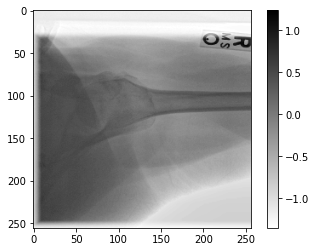

In [79]:
print_img_with_colorbar(X_train[0])

In [80]:
def print_range_images(images, images_label):
    '''
    print the first 25 images with their labels
    
    images: a array of images
    images_label: a array with the label of each image
    class_names: a list with the labels name of each class
    '''
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(images_label[i])

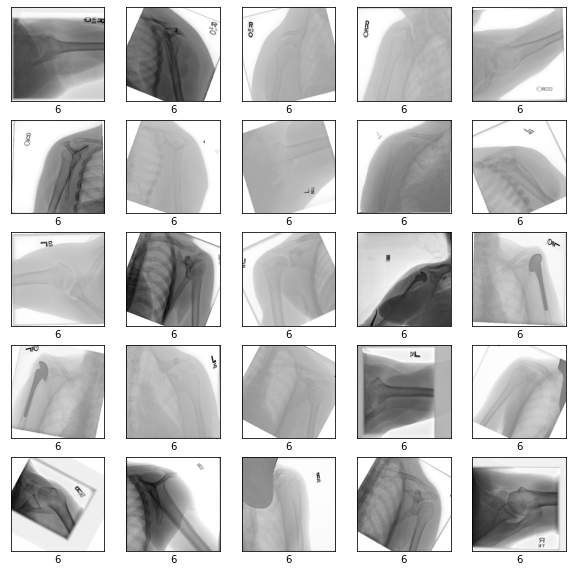

In [81]:
print_range_images(X_train, y_train)

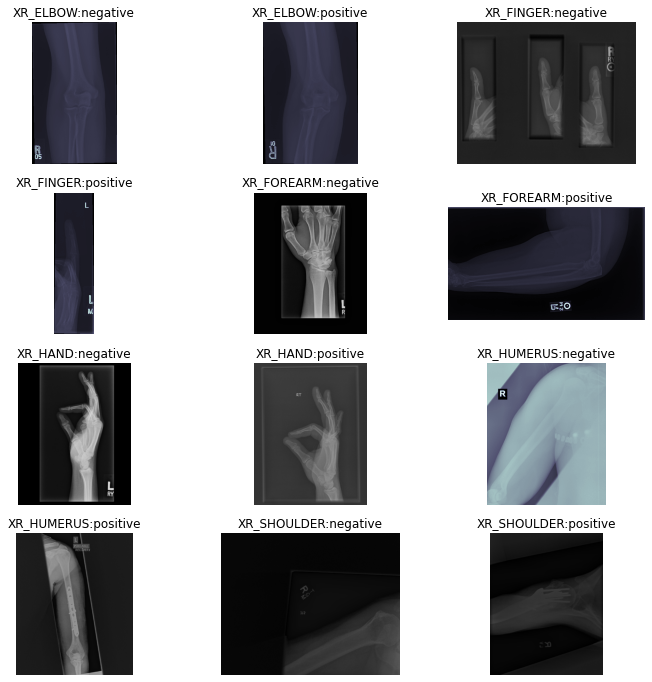

In [82]:
from skimage.io import imread

sub_df = train_images_paths.groupby(['category', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['image_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{category}:{label}'.format(**c_row))

# Machine Learning Models

## Splitting dataset

In [83]:
train, valid = train_test_split(train_images_paths, 
                               test_size=0.2,
                               random_state=seed)

In [84]:
test = valid_data_paths.drop(['dir'], axis=1)
test.shape

(3197, 5)

## Image Preparing

In [85]:
im_size = 256

In [86]:
image_generator_settings = dict(
                          rescale = 1. / 255
                          #samplewise_center = True,
                          #samplewise_std_normalization = True,
                          #rotation_range = 5, 
                         )

image_generator = ImageDataGenerator(**image_generator_settings)

In [87]:
path = 'MURA-v1.1'

In [88]:
train_generator = image_generator.flow_from_dataframe(
    dataframe = train,
    directory = None,
    x_col = 'image_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary', #"binary"
    target_size = (im_size, im_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=False,
    seed=seed)

Found 29446 non-validated image filenames belonging to 2 classes.


In [89]:
valid_generator = image_generator.flow_from_dataframe(
    dataframe = valid,
    directory = None,
    x_col = 'image_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary',
    target_size = (im_size, im_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=True,
    seed=seed)

Found 7362 validated image filenames belonging to 2 classes.


In [90]:
test_generator = image_generator.flow_from_dataframe(
    dataframe = test,
    directory = None,
    x_col = 'image_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = False,
    class_mode = 'binary',
    target_size = (im_size, im_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=True,
    seed=seed)

Found 3197 validated image filenames belonging to 2 classes.


## Initialization

In [91]:
CLASSES = 2

In [92]:
input_shape = (im_size,im_size,3)   
print(input_shape)

(256, 256, 3)


### Metrics

In [93]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

### Plotting results

In [94]:
def plot_history(hs, epochs, metric):

    if metric=='loss': 
                label_y = 'Loss'
    elif metric=='accuracy': 
               label_y = 'Accuracy'
    elif metric=='auc': 
               label_y = 'AUC'
    else : label_y = 'kappa'


    print()
    #plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

In [95]:
def print_results(model_name,
                  epochs,
                  hs,
                  model_eval):

    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))


    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

### Cleaning up

In [96]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()
    print("...Finished clean up...")

## CNN

In [97]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

In [98]:
from tensorflow import keras
from keras import optimizers

### Architecture

### Models

#### CNN basic

In [99]:
epochs = 100

In [100]:
# from tensorflow.keras.losses import categorical_crossentropy

In [101]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to build InceptionV3 model with dropout and additional layers
def build_inceptionv3_model(input_shape, dropout_rate=0.5):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='selu')(x)
    x = Dropout(dropout_rate)(x)  # Add dropout layer
    x = Dense(64)(x)  # Additional dense layer
    x = Activation('selu')(x)  # Activation function 'relu'
    x = Dense(32)(x)  # Additional dense layer
    x = Activation('selu')(x)  # Activation function 'selu'
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification with sigmoid activation

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Assuming you have train_generator, valid_generator, test_generator defined

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(df_train['label']), y=df_train['label'])
class_weight_dict = dict(enumerate(class_weights))

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)

# Build InceptionV3 model with dropout and additional layers
dropout_rate = 0.5  # You can adjust the dropout rate
inceptionv3_model = build_inceptionv3_model(input_shape=(im_size, im_size, 3), dropout_rate=dropout_rate)

# Compile the model
inceptionv3_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with class weights
hs = inceptionv3_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    class_weight=class_weight_dict,  # Pass class weights here
    callbacks=[early_stop]
)


# Print model summary
print('Finished training.')
print('------------------')
inceptionv3_model.summary()



87924736/87910968 [==============================] - 5s 0us/step
Epoch 1/100
461/461 [==============================] - 462s 971ms/step - loss: 0.6392 - accuracy: 0.6516 - val_loss: 0.8621 - val_accuracy: 0.5891
Epoch 2/100
461/461 [==============================] - 294s 637ms/step - loss: 0.5585 - accuracy: 0.7285 - val_loss: 0.7651 - val_accuracy: 0.6778
Epoch 3/100
461/461 [==============================] - 290s 628ms/step - loss: 0.5299 - accuracy: 0.7502 - val_loss: 0.6397 - val_accuracy: 0.6111
Epoch 4/100
461/461 [==============================] - 287s 623ms/step - loss: 0.5137 - accuracy: 0.7604 - val_loss: 0.5658 - val_accuracy: 0.7186
Epoch 5/100
461/461 [==============================] - 299s 647ms/step - loss: 0.5020 - accuracy: 0.7686 - val_loss: 0.5935 - val_accuracy: 0.7046
Epoch 6/100
461/461 [==============================] - 288s 625ms/step - loss: 0.4787 - accuracy: 0.7856 - val_loss: 0.5689 - val_accuracy: 0.7593
Epoch 7/100
461/461 [==============================] 

In [102]:
# Make predictions on the test set using InceptionV3 model
y_pred_probs_inceptionv3 = inceptionv3_model.predict(test_generator)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs_inceptionv3 > 0.5).astype(int)

# Convert one-hot encoded true labels to class labels
y_true_labels = test_generator.labels

# Calculate AUROC
auroc = roc_auc_score(y_true_labels, y_pred_probs_inceptionv3)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true_labels, y_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print or use the calculated values as needed
print("AUROC (InceptionV3):", auroc)
print("Sensitivity (InceptionV3):", sensitivity)
print("Specificity (InceptionV3):", specificity)


AUROC (InceptionV3): 0.838168052663977
Sensitivity (InceptionV3): 0.6823529411764706
Specificity (InceptionV3): 0.8632273545290942


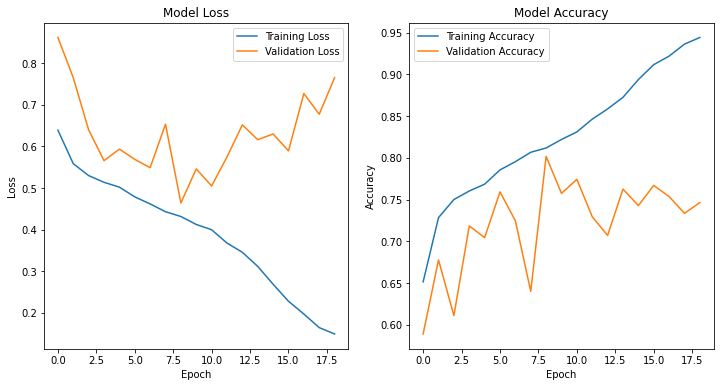

In [103]:
import matplotlib.pyplot as plt

# Assuming 'hs' is the training history returned by the fit method
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(hs.history['loss'], label='Training Loss')
plt.plot(hs.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(hs.history['accuracy'], label='Training Accuracy')
plt.plot(hs.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



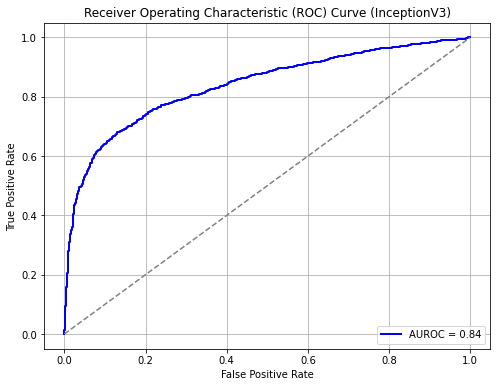

In [104]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate fpr, tpr, and thresholds for the positive class
fpr, tpr, thresholds = roc_curve(y_true_labels, y_pred_probs_inceptionv3)

# Calculate AUROC
auroc = roc_auc_score(y_true_labels, y_pred_probs_inceptionv3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (InceptionV3)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [105]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred_inceptionv3 = inceptionv3_model.predict(test_generator)

# Convert probabilities to class labels
y_pred_classes_inceptionv3 = (y_pred_inceptionv3 > 0.5).astype(int)

# Get true class labels
y_true_inceptionv3 = test_generator.labels

# Generate classification report
report_inceptionv3 = classification_report(y_true_inceptionv3, y_pred_classes_inceptionv3)

print("Classification Report (InceptionV3):\n", report_inceptionv3)



Classification Report (InceptionV3):
               precision    recall  f1-score   support

           0       0.75      0.86      0.80      1667
           1       0.82      0.68      0.75      1530

    accuracy                           0.78      3197
   macro avg       0.78      0.77      0.77      3197
weighted avg       0.78      0.78      0.77      3197



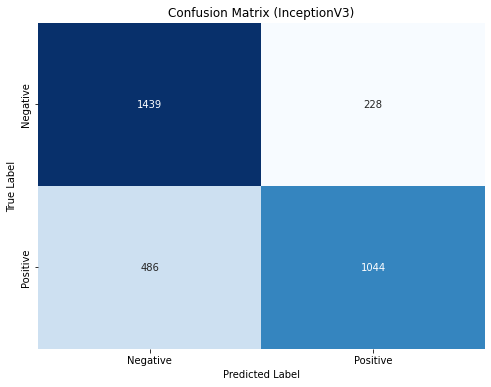

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set using the InceptionV3 model
y_pred_inceptionv3 = inceptionv3_model.predict(test_generator)

# Convert probabilities to class labels
y_pred_classes_inceptionv3 = (y_pred_inceptionv3 > 0.5).astype(int)

# Get true class labels
y_true_inceptionv3 = test_generator.labels

# Generate confusion matrix
conf_matrix_inceptionv3 = confusion_matrix(y_true_inceptionv3, y_pred_classes_inceptionv3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_inceptionv3, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix (InceptionV3)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [107]:
# # Save the model in HDF5 format
# filename_h5 = '/kaggle/working/format1/model_CAT.h5'
# densenet_model.save(filename_h5)
# print('> Saved %s' % filename_h5)


In [108]:
# from PIL import Image
# import numpy as np

# # Load the uploaded image
# uploaded_image_path = "/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOULDER/patient00008/study1_positive/image1.png"  # Update with the path to your uploaded image
# uploaded_image = Image.open(uploaded_image_path)

# # Preprocess the image
# uploaded_image = uploaded_image.resize((256, 256))  # Resize to match the input size of the model
# uploaded_image = uploaded_image.convert("RGB")      # Convert to RGB format
# uploaded_image = np.array(uploaded_image) / 255.0   # Normalize pixel values

# # Ensure the image has the correct shape (add batch dimension)
# uploaded_image = np.expand_dims(uploaded_image, axis=0)

# # Make predictions using the model
# predictions = densenet_model.predict(uploaded_image)

# # Interpret the predictions
# if predictions[0][0] > predictions[0][1]:
#     print("The image is predicted to be negative (normal).")
# else:
#     print("The image is predicted to be positive (abnormal).")
